# Exploratory Model Analysis

*Purpose*: **TODO**.


## Core Idea: Curiosity and Skepticism

Remember the core principles of EDA:

1. Curiosity: Generate lots of ideas and hypotheses about your data.
2. Skepticism: Remain unconvinced of those ideas, unless you can find credible patterns to support them.

We can apply these same principles when studying a model; a process called *exploratory model analysis*. However, when studying a model, we have the means to more immediately test our hypotheses: We can *evaluate* the model to generate new data as we're carrying out our exploration!

These ideas can be a little abstract, so let's illustrate them with a concrete example.


## Setup


In [1]:
import grama as gr
DF = gr.Intention()
%matplotlib inline

## Running Example: Circuit model


In [2]:
from grama.models import make_prlc_rand
md_circuit = make_prlc_rand()

# Basic Facts


### __qX__ Model summary


In [3]:
md_circuit 
# solution-end

/Users/zach/Git/py_grama/grama/marginals.py:336: RuntimeWarning: divide by zero encountered in double_scalars


model: RLC with component tolerances

  inputs:
    var_det:
      L: [1e-09, 0.001]
      C: [0.001, 100]
      R: [0.001, 1.0]

    var_rand:
      dR: (+0) uniform, {'mean': '0.000e+00', 's.d.': '3.000e-02', 'COV': inf, 'skew.': 0.0, 'kurt.': 1.8}
      dL: (+0) uniform, {'mean': '0.000e+00', 's.d.': '6.000e-02', 'COV': inf, 'skew.': 0.0, 'kurt.': 1.8}
      dC: (+0) uniform, {'mean': '3.000e-01', 's.d.': '2.900e-01', 'COV': 0.96, 'skew.': 0.0, 'kurt.': 1.8}

    copula:
      Independence copula

  functions:
      f0: ['R', 'dR', 'L', 'dL', 'C', 'dC'] -> ['Rr', 'Lr', 'Cr']
      f1: ['Lr', 'Cr'] -> ['omega0']
      parallel RLC: ['omega0', 'Rr', 'Cr'] -> ['Q']

*Observations*

- Compare the variability (measured by standard deviation) of the three random variables. Which is most variable?
  - `dC` has the largest variability, with `sd = 0.29`, as compared with `dR` (`sd = 0.03`) and `dL` (`sd = 0.06`).


## Model context

The deterministic variables `L, R, C` are the *designed* component values.

The random variables `dL, dR, dC` are *perturbations* to the designed component values.


# Inputs

## Assess input variability


### __qX__ Overview of inputs


eval_sample() is rounding n...
Design runtime estimates unavailable; model has no timing data.
Calling plot_scattermat....


/Users/zach/Git/py_grama/grama/plot_auto.py:234: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


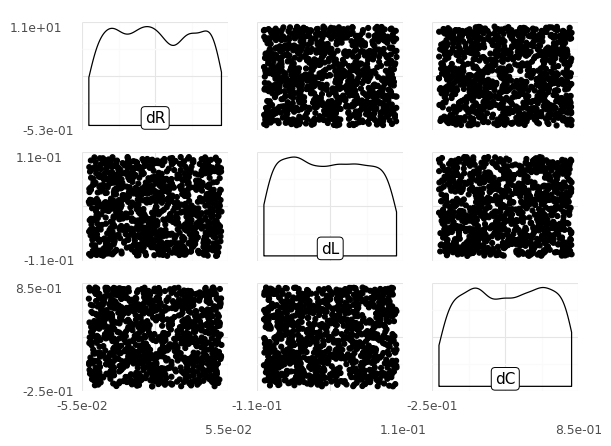

In [4]:
(
    md_circuit
    >> gr.ev_sample(n=1e3, df_det="nom", skip=True)
    >> gr.pt_auto()
)

*Observations*



Here's a hypothesis:

> Since the random perturbations `dL, dR, dC` are mutually independent, we should see the same variability regardless of the circuit component values.

You'll assess this hypothesis in the next task.


### __qX__ Compare designed and realized values

The following plot shows the designed and realized capacitance values. Answer the questions under *observations* below.

*Hint*: Remember that you can add `gr.scale_x_log10()` and `gr.scale_y_log10()` to a ggplot to change to a log-log scale.


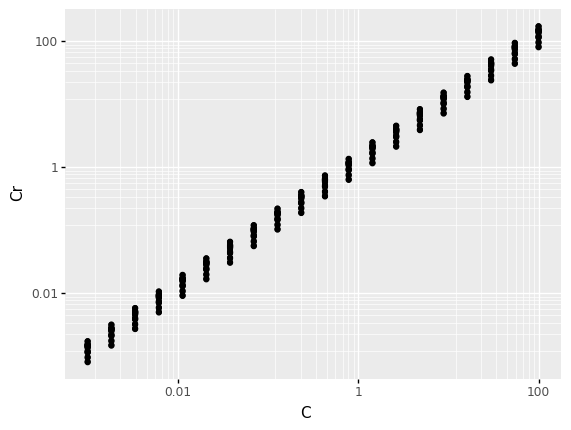

<ggplot: (8785794962261)>

In [5]:
# TASK: Inspect the following plot
(
    # NOTE: No need to edit this part of the code
    md_circuit
    >> gr.ev_sample(
        n=20,
        df_det=gr.df_make(
            R=1e-1,
            L=1e-5,
            C=gr.logspace(-3, 2, 20)
        )
    )
    # Visualize
    >> gr.ggplot(gr.aes("C", "Cr"))
    + gr.geom_point()
    + gr.scale_x_log10()
    + gr.scale_y_log10()
)

*Observations*

- Consider the hypothesis `we should see the same variability regardless of the circuit component values`. Is this hypothesis true?
  - This really depends on how we define "same variability"; since the variability is proportional to the component values (defined in terms of $\pm$ a fixed percentage), the variability  is greater for larger component values. However, the percentage variability is consistent regardless of the component value; this is easiest to see on a log-log scale.


# Outputs


### __qX__ Overview of outputs


eval_sample() is rounding n...
Calling plot_hists....


/Users/zach/opt/anaconda3/envs/evc/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/Users/zach/opt/anaconda3/envs/evc/lib/python3.9/site-packages/plotnine/facets/facet.py:390: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.
/Users/zach/opt/anaconda3/envs/evc/lib/python3.9/site-packages/plotnine/facets/facet.py:396: PlotnineWarning: If you need more space for the y-axis tick text use ... + theme(subplots_adjust={'hspace': 0.25}). Choose an appropriate value for 'hspace'


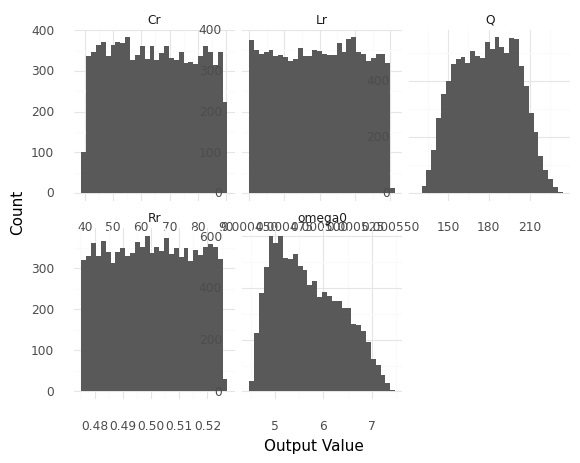

<ggplot: (8785792463475)>

In [6]:
(
    md_circuit
    >> gr.ev_sample(n=1e4, df_det="nom")
    >> gr.pt_auto()
)

*Observations*

*Note*: If you can't reliably make out the shapes of the distributions, try increasing `n`.

- What distribution shapes do the realized component values `Lr, Rr, Cr` have?
  - These are all uniform distributions
- What distribution shape does the output `Q` have?
  - This distribution is a bit bell-shaped, but it has a much flatter top and narrower tails than a gaussian.
- What distribution shape does the output `omega0` have?
  - This distribution is strongly asymmetric, with a longer right tail (right skew).


### __qX__ Density of outputs

Visualize `Q` and `omega0` with a 2d bin plot. Increase the sample size `n` to get a "full" plot.


eval_sample() is rounding n...


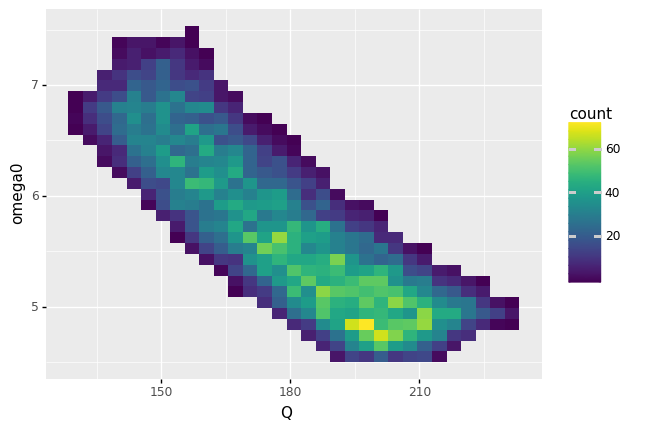

<ggplot: (8785775758626)>

In [7]:
(
    md_circuit
    >> gr.ev_sample(n=1e4, df_det="nom")
    >> gr.ggplot(gr.aes("Q", "omega0"))
    + gr.geom_bin2d()
)

*Observations*

- Briefly describe the distribution of realized performance (values of `Q` and `omega0`).
  - The distribution is oddly rectangular, with fairly "sharp" square sides. The distribution seems to end abruptly; there are exactly zero counts outside the "curved rectangle". The values of `Q` and `omega0` are negatively correlated; when `Q` is larger `omega0` tends to be smaller. The distribution is also asymmetric; note that highest `count` (brightest fill color) is *not* in the center, but rather towards the bottom-right.


### __qX__ Compare nominal with distribution


eval_sample() is rounding n...


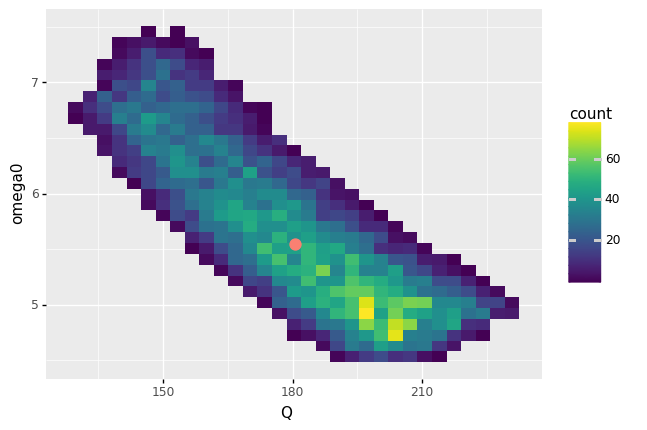

<ggplot: (8785792469697)>

In [8]:
(
    md_circuit
    >> gr.ev_sample(n=1e4, df_det="nom")
    
    >> gr.ggplot(gr.aes("Q", "omega0"))
    + gr.geom_bin2d()
    + gr.geom_point(

        data=md_circuit
        >> gr.ev_nominal(df_det="nom"),
        color="salmon",
        size=4,
    )
)

*Observations*

The nominal design (red point) represents the predicted performance if we assume the nominal circuit component values. 

- How does the distribution of real circuit performance (values of `Q`, `omega0`) compare with the nominal performance?
  - The distribution of real performance is quite large, and not at all symmetric about the nominal performance. The values `Q` and `omega0` exhibit negative correlation: when `Q` is larger `omega0` tends to be smaller.
- Is the most likely performance (values of `Q`, `omega0`) the same as the nominal performance? ("Most likely" is where `count` is the largest.)
  - No; the most likely performance is at a larger value of `Q` and smaller value of `omega0`.
- Assume that another system depends on the particular values of `Q` and `omega0` provided by this system. Would it be safe to assume the performance is within 1% of the nominal performance?
  - No; we see variability in `Q` and `omega0` far greater than 1%!


# Input-to-output Relationships

TODO


### __qX__ Correlation tile plot

Use the routine `tf_iocorr()` to transform the data from `ev_sample()` into input-to-output correlations. The `pt_auto()` routine will automatically plot those correlations as colors on a tile plot. Study the correlation tile plot, and answer the questions under *observations* below.


eval_sample() is rounding n...
Calling plot_corrtile....


/Users/zach/opt/anaconda3/envs/evc/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
/Users/zach/opt/anaconda3/envs/evc/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
/Users/zach/opt/anaconda3/envs/evc/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
/Users/zach/opt/anaconda3/envs/evc/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
/Users/zach/opt/anaconda3/envs/evc/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
/Users/zach/opt/anac

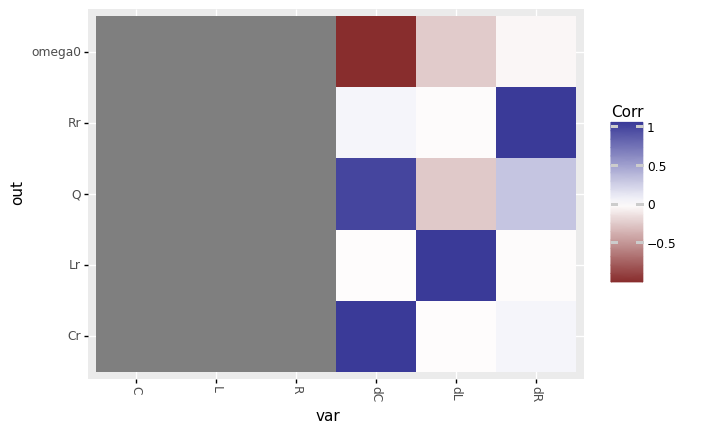

<ggplot: (8785775272792)>

In [9]:
(
    ## NOTE: No need to edit the call to ev_sample()
    md_circuit
    >> gr.ev_sample(
        n=1e3, 
        df_det="nom",
    )

    >> gr.tf_iocorr()
    ## NOTE: No need to edit; pt_auto will automatically
    ## adjust the plot to use the correlation data
    >> gr.pt_auto()
)

*Observations*

- Do we have any information on how the outputs `omega0` and `Q` depend on the deterministic inputs `L, R, C`? Why do you think that is?
  - No; the correlations between the outputs `omega0` and `Q` and inputs `L, R, C` are invalid. This is because we set `df_det="nom"` in the sample above; there is no variability in the inputs `L, R, C` by which to judge correlation with the outputs.
- Based on the available information: Which inputs does `omega0` depend on? How do those inputs affect `omega0`?
  - `omega0` depends on `dC` and `dL`; from this we can guess that is also depends on `C` and `L`. `omega0` is strongly negatively correlated with `dC`, and weakly negatively correlated with `dL`.
- Based on the available information: Which inputs does `Q` depend on? How do those inputs affect `Q`?
  - `Q` depends on all of `dC`, `dL`, and `dR`; from this we can guess that it also depends on `C, L, R`. `Q` is strongly positively correlated with `dC`, weakly positively correlated with `dR`, and weakly negatively correlated with `dL`.


### __qX__ Targeted scatterplots

(Use this to get more detailed view)


### __qX__ Sinew plot


Calling plot_sinew_outputs....


/Users/zach/opt/anaconda3/envs/evc/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


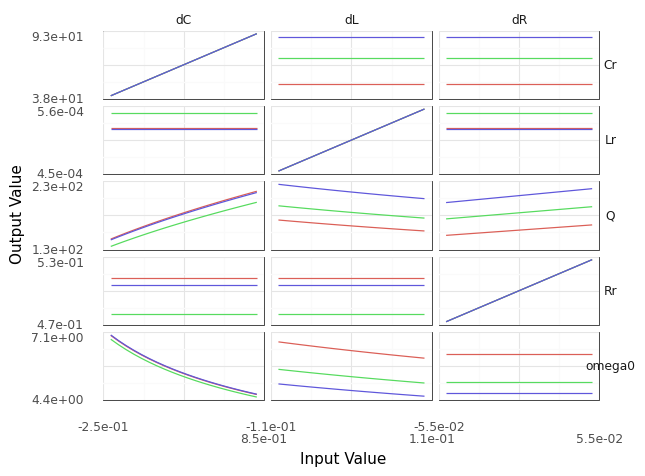

<ggplot: (8785794959601)>

In [10]:
(
    md_circuit
    >> gr.ev_sinews(df_det="nom", n_density=20)
    >> gr.pt_auto()
)

*Observations*

